In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import importlib as il

import itertools as it
import random
import warnings

from scipy import optimize
from addict import Addict

# needed?
from skimage.transform import hough_line, hough_line_peaks, rotate
from skimage.feature import canny
from skimage.io import imread

%load_ext ipydex.displaytools
%matplotlib inline

In [2]:
import stage_2a_bar_selection as bs
il.reload(bs)

<module 'stage_2a_bar_selection' from '/home/ck/iee-ge/XAI-DIA/image_classification/stage2/stage_2a_bar_selection.py'>

In [3]:
from stage_2a_bar_selection import (
    load_img,
    rgb,
    get_bbox_list,
    assign_row_col,
    index_combinations,
    find_missing_boxes,
    handle_missing_boxes,
    select_bar_from_file,
    Attr_Array,
    rotate_img,
    CavityCarrierImageAnalyzier,

)


img_dir = "/home/ck/mnt/XAI-DIA-gl/Carsten/bilder_jpg2a/cropped/chunk000_stage1_completed/C0"
img_fpath = f"{img_dir}/2023-06-26_06-17-52_C50.jpg"

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

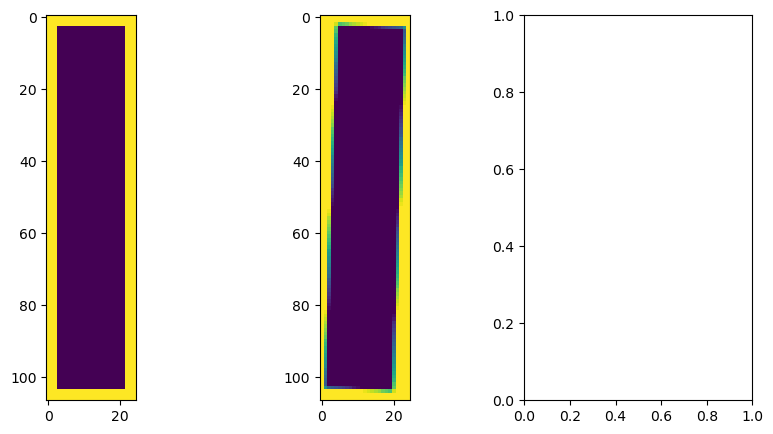

In [4]:
# test rect
test_img = np.ones((107, 25))*255
e = 3
test_img[e:-e , e:-e] = 65

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5));
ax1.imshow(test_img)

test_img2 = bs.rotate_img(test_img, -2)
ax2.imshow(test_img2)

plt.sca(ax3)

params = []



In [5]:
# Attempt to deploy the method of image moments to determine orientation
# http://raphael.candelier.fr/?blog=Image%20Moments&page=1#comments

$\bar{x} = \frac{M_{1,0}}{M_{0,0}}$, $\bar{y} = \frac{M_{0,1}}{M_{0,0}}$


$\mu_{2,0}' = \frac{M_{2,0}}{M_{0,0}} - \bar{x}^2$

$\mu_{1,1}' = \frac{M_{1,1}}{M_{0,0}} - \bar{x}\bar{y}$

$\mu_{0,2}' = \frac{M_{0,2}}{M_{0,0}} - \bar{y}^2$

$\theta = \frac{1}{2}.tan^{-1} \left( \frac{2\mu_{1,1}'}{\mu_{2,0}'-\mu_{0,2}'} \right)$

In [6]:

def get_angle_from_moments(img):

    M = Addict(cv2.moments(img))

    X = M.m10 / M.m00
    Y = M.m01 / M.m00

    MU20 = M.m20 / M.m00 - X**2
    MU11 = M.m11 / M.m00 - X*Y
    MU02 = M.m02 / M.m00 - Y**2

    theta = 0.5 * np.arctan(2*MU11 / (MU20 - MU02)) * 180/np.pi
    return theta

CPU times: user 140 ms, sys: 3.54 ms, total: 143 ms
Wall time: 142 ms


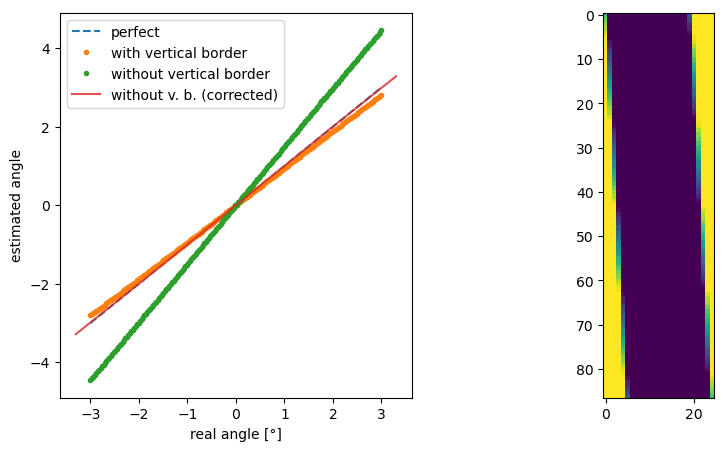

In [7]:
%%time


pp = []
pp2 = []
angles = np.linspace(-3, 3, 200)

for angle in angles:
    
    test_img2 = bs.rotate_img(test_img, angle)
    p = get_angle_from_moments(test_img2[:])
    pp.append(p)
    
    # vertical cutoff
    vc = 10
    pp2.append(get_angle_from_moments(test_img2[vc:-vc]))
    
pp = np.array(pp)
pp2 = np.array(pp2) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5));
plt.sca(ax1)

plt.plot(angles, angles, "--", label="perfect")
plt.plot(angles, pp, ".", label="with vertical border")
plt.plot(angles, pp2, ".", label="without vertical border")
plt.plot(angles*1.1, 1.1*pp2*.67, "-", label="without v. b. (corrected)", alpha=0.8)
plt.xlabel("real angle [°]")
plt.ylabel("estimated angle")
plt.legend()
ax2.imshow(test_img2[vc:-vc])

### Interim summary

- Method of moments is fast and seems reliable (on artificial images)
- if the vertical border is missing a linear correction is necessary



back to chocolate bars

In [8]:
ccia = CavityCarrierImageAnalyzier(img_fpath)

cell = ccia.get_raw_cell("a", "4", 3, 3)

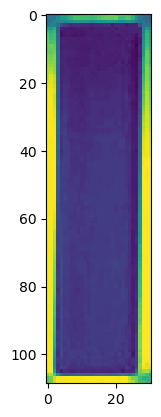

In [9]:
plt.imshow(cell)

In [10]:
%%time
get_angle_from_moments(cell)

CPU times: user 1.95 ms, sys: 673 µs, total: 2.62 ms
Wall time: 1.4 ms


-0.8767322438844154

In [11]:
%%time
bs.get_angle_from_hough(cell)

CPU times: user 4.71 ms, sys: 8.27 ms, total: 13 ms
Wall time: 3.95 ms


0.6499999999999798

In [12]:
il.reload(bs)

<module 'stage_2a_bar_selection' from '/home/ck/iee-ge/XAI-DIA/image_classification/stage2/stage_2a_bar_selection.py'>